Mając już dane zabieram się za implementacji vq-vae dla naszego zbioru

In [ ]:
import torch.optim as optim
import numpy as np
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from PIL import Image
import io
from datasets import load_from_disk
import torch.nn as nn
import torch.nn.functional as F
import torch
from google.colab import drive
from pathlib import Path
import math

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Wczytanie i przetworzenie

## wczytanie

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk('/content/drive/MyDrive/projekt-ml/minecraft_dataset_2')
ds = dataset.to_pandas()
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
3957,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3958,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3959,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3960,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
ds.shape

(3962, 4)

## przetworzenie zbioru

In [ ]:
mask = []
for index, row in ds.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    mask.append((img.width == 16) & (img.height == 16))

ds = ds[mask]
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
3957,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3958,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3959,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3960,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
ds.shape

(3943, 4)

## Stworzenie dataloader

In [ ]:
class MinecraftDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = Compose([
            ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # get image
        img_bytes = self.dataframe.iloc[idx]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert("RGBA")
        img_tensor = self.transform(img)
        img_tensor = (img_tensor - 0.5) / 0.5  # normalization

        is_block = float(self.dataframe.iloc[idx]['is_block'])
        is_block = torch.tensor(is_block, dtype=torch.float32)

        type_ = self.dataframe.iloc[idx]['type']
        type_tensor = torch.tensor(type_, dtype=torch.float32).flatten()

        colors = self.dataframe.iloc[idx]['colors']
        colors_tensor = torch.tensor(colors, dtype=torch.float32).flatten()

        return img_tensor, is_block, type_tensor, colors_tensor

In [ ]:
# parameters
batch_size = 32
lr = 1e-4

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
use_cuda

True

In [ ]:
dataset = MinecraftDataset(ds)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Trening

In [ ]:
dataiter = iter(train_loader)
test_1 = next(dataiter)[0]
test_2 = next(dataiter)[0]
test_3 = next(dataiter)[0]
test_images = torch.cat((test_1, test_2, test_3), 0)


print(test_images.shape) # batch size, number of columns, img_x, img_y

torch.Size([96, 4, 16, 16])


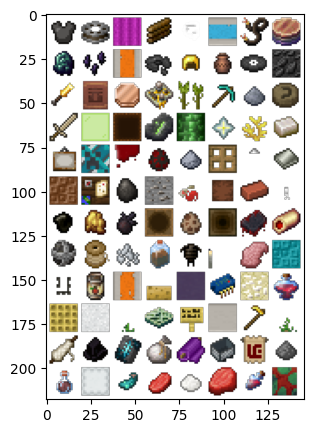

In [ ]:
plt.figure(figsize = (5,5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

### nasza sieć

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1/code_book_size, 1/code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # BSxCxHxW --> BSxHxWxC
        input_shape = inputs.shape

        flat_input = inputs.view(-1, 1, self.embedding_dim)  # BSxHxWxC --> BS*H*Wx1xC

        # Calculate the distance between each embedding and each codebook vector
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)  # BS*H*WxN

        # Find the closest codebook vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # BS*H*Wx1

        # Select that codebook vector
        quantized = self.embedding(encoding_indices).view(input_shape)

        # Create loss that pulls encoder embeddings and codebook vector selected
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Reconstruct quantized representation using the encoder embeddings to allow for
        # backpropagation of gradients into encoder
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        skip = x

        x = F.elu(self.norm1(x))
        x = F.elu(self.norm2(self.conv1(x)))
        x = self.conv2(x) + skip
        return x


# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn2 = nn.GroupNorm(8, channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x = F.elu(self.bn1(x))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.GroupNorm(8, channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = self.up_nn(F.elu(self.bn1(x_in)))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip

# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch * 2)
        self.conv_block2 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_out = nn.Conv2d(4 * ch, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv_1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = F.elu(self.res_block_3(x))

        return self.conv_out(x)


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(latent_channels, 4 * ch, 3, 1, 1)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_2(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        return torch.tanh(self.conv_out(x))

class VQVAE(nn.Module):
    def __init__(self,
                 channel_in,
                 ch=16,
                 latent_channels=32,
                 code_book_size=64,
                 commitment_cost=0.25,
                 cond_type_dim=8,     # len(type)
                 cond_colors_dim=8,   # len(colors)
                 cond_hidden=256):    # for condition
        super(VQVAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        self.vq = VectorQuantizer(code_book_size=code_book_size,
                                  embedding_dim=latent_channels,
                                  commitment_cost=commitment_cost)

        self.decoder = Decoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        # conditioning: is_block (1), type (cond_type_dim), colors (cond_colors_dim)
        self.cond_in_dim = 1 + cond_type_dim + cond_colors_dim
        self.cond_hidden = cond_hidden
        self.latent_channels = latent_channels

        # MLP to map condition vector -> latent_channels
        self.cond_fc = nn.Sequential(
            nn.Linear(self.cond_in_dim, self.cond_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.cond_hidden, latent_channels)
        )

    def encode(self, x, is_block=None, type_=None, colors=None):
        encoding = self.encoder(x)

        if is_block is not None and type_ is not None and colors is not None:
            cond_vec = torch.cat([is_block.unsqueeze(1), type_, colors], dim=1)  # (B, cond_dim)
            cond_proj = self.cond_fc(cond_vec)  # (B, latent_channels)

            # reshape to (B, latent_channels, 1, 1) and broadcast add
            cond_proj = cond_proj.unsqueeze(-1).unsqueeze(-1)
            encoding = encoding + cond_proj

        vq_loss, quantized, encoding_indices = self.vq(encoding)
        return vq_loss, quantized, encoding_indices

    def decode(self, x, is_block=None, type_=None, colors=None):
        if is_block is not None and type_ is not None and colors is not None:
            cond_vec = torch.cat([is_block.unsqueeze(1), type_, colors], dim=1)
            cond_proj = self.cond_fc(cond_vec)  # (B, latent_channels)
            cond_proj = cond_proj.unsqueeze(-1).unsqueeze(-1)
            x = x + cond_proj

        return self.decoder(x)

    def forward(self, x, is_block=None, type_=None, colors=None):
        vq_loss, quantized, encoding_indices = self.encode(x, is_block, type_, colors)
        recon = self.decode(quantized, is_block, type_, colors)
        return recon, vq_loss, quantized

### definicja parametrów uczenia

In [ ]:
# The number of code book embeddings
code_book_size =  512

# The number of latent embedding channels
latent_channels = 256

# Number of Training epochs
vq_nepoch = 500

type_dim = len(ds.iloc[0]['type'])
colors_dim = len(ds.iloc[0]['colors'])

vae_net = VQVAE(channel_in=4, latent_channels=latent_channels, ch=128,
                code_book_size=code_book_size, commitment_cost=0.50,
                cond_type_dim=type_dim, cond_colors_dim=colors_dim, cond_hidden=256).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, weight_decay=1e-5)
scaler = torch.amp.GradScaler('cuda')

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=vq_nepoch, eta_min=0)

# Create loss logger
recon_loss_log = []
qv_loss_log = []
test_recon_loss_log = []
train_loss = 0

In [ ]:
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]

print("-The VQVAE Model Has %d (Approximately %d Million) Parameters!" % (num_model_params,
                                                                          num_model_params//1e6))

-The VQVAE Model Has 38004612 (Approximately 38 Million) Parameters!


In [ ]:
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

quantized.shape

torch.Size([96, 256, 4, 4])

## Sprawdzenie metryk po treningu

In [ ]:
vae_net.load_state_dict(torch.load('/content/drive/MyDrive/projekt-ml/vae_net2.pth'))

<All keys matched successfully>

In [ ]:
vae_net.eval()
dataiter = iter(train_loader)
test_batch = next(dataiter)
image = test_batch[0].to(device)
is_block = test_batch[1].to(device)
type_ = test_batch[2].to(device)
colors = test_batch[3].to(device)

with torch.no_grad():
    recon_data, _, _ = vae_net(image, is_block=is_block, type_=type_, colors=colors)

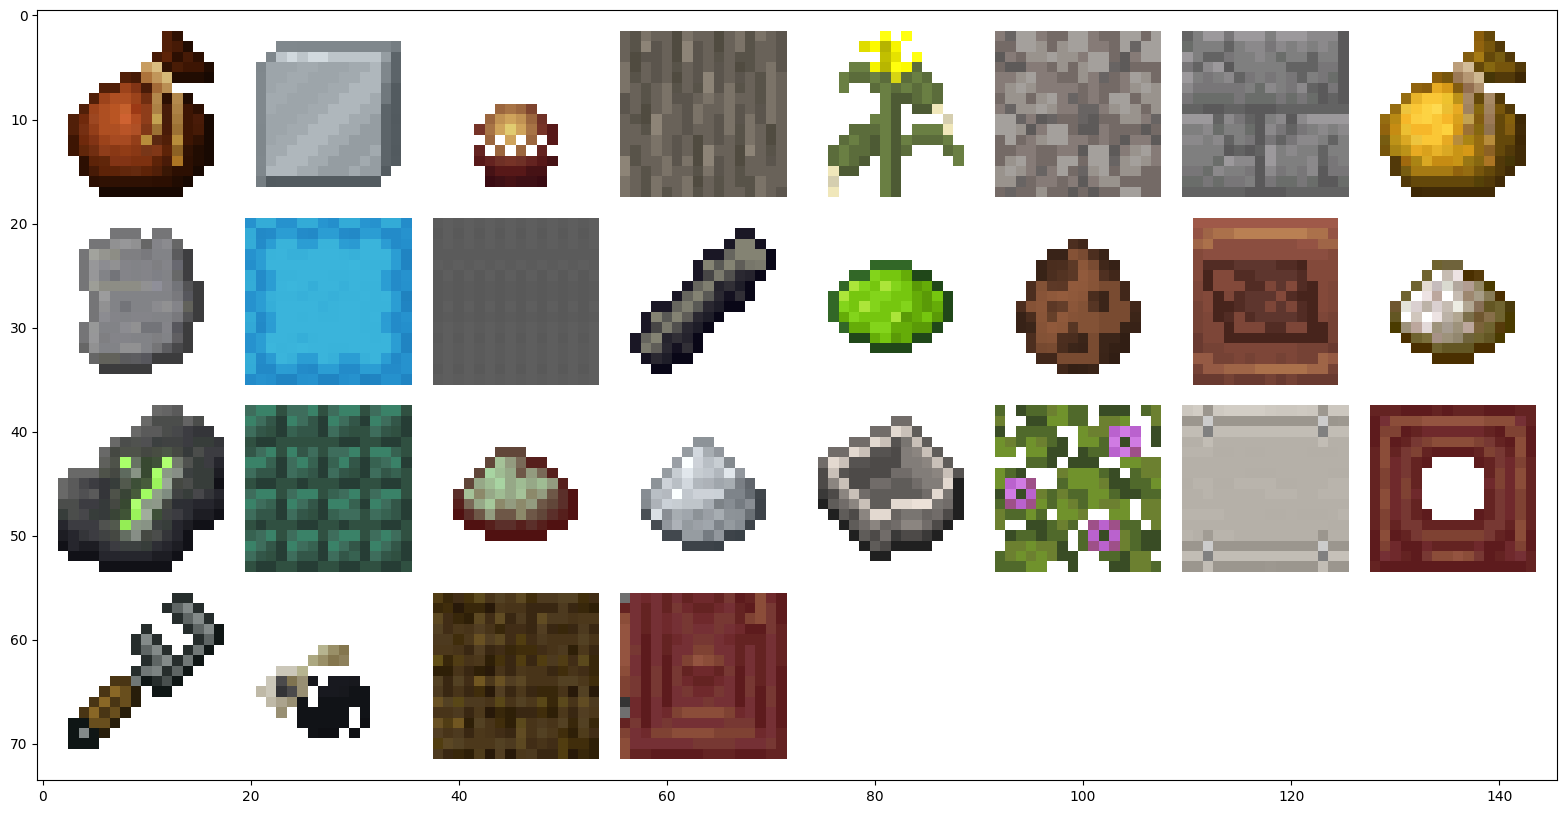

In [ ]:
# ground truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_batch[0][0:28], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

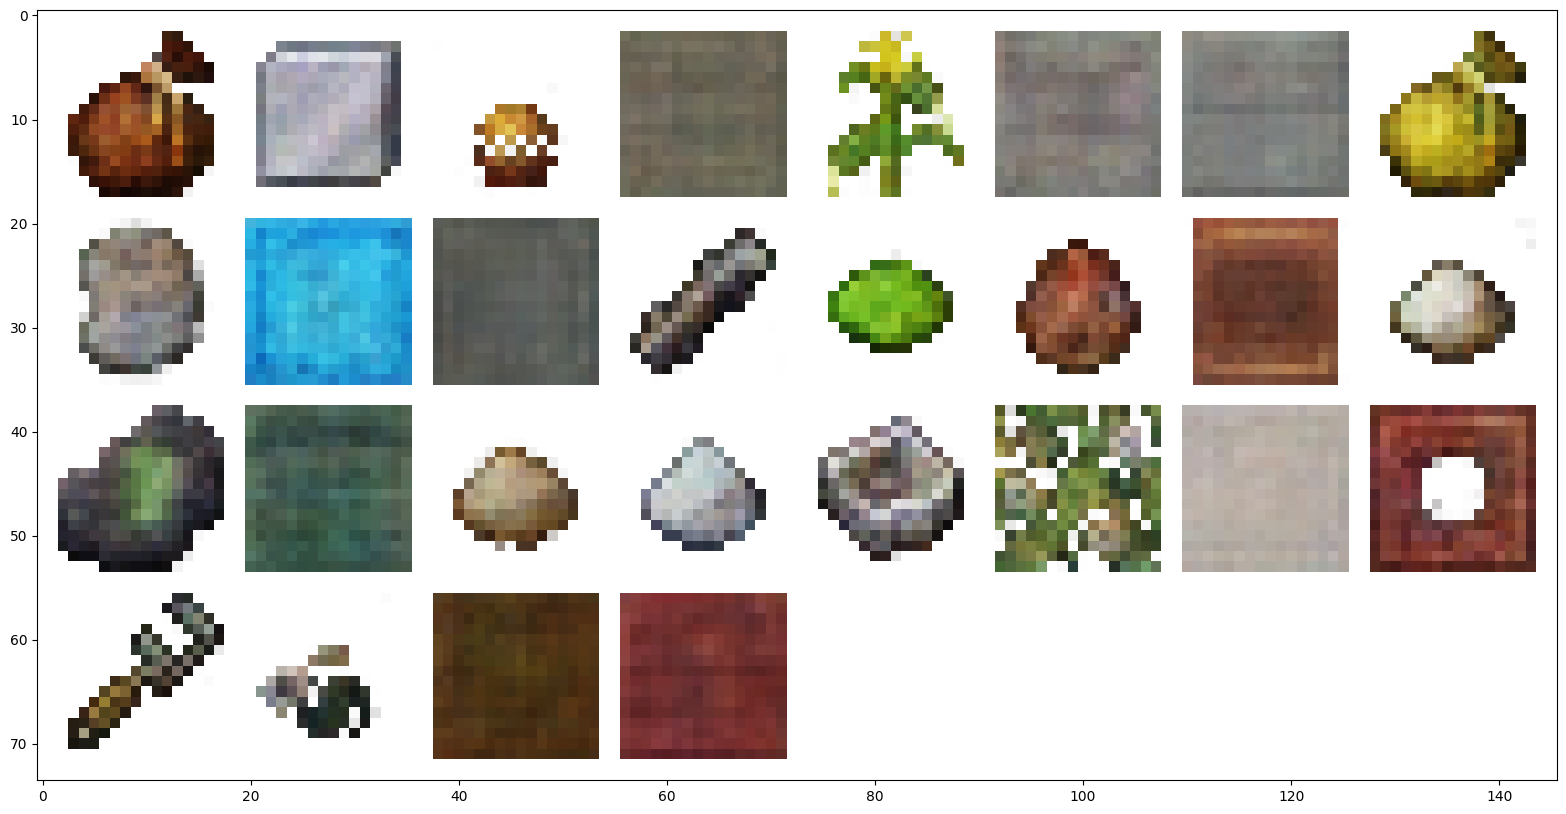

In [ ]:
# reconstruction
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:28], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

Defining Transformer

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x):
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=x.device), diagonal=1)
        # Self-attention with residual connection
        attn_output, _ = self.attention(x, x, x, attn_mask=causal_mask)
        x = x + attn_output
        x = self.norm1(x)

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x)
        x = x + ffn_output
        x = self.norm2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, hidden_size=128, num_layers=3, num_heads=4):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Transformer(nn.Module):
    def __init__(self, num_emb, hidden_size=256, num_layers=3, num_heads=8,
                 cond_type_dim=8, cond_colors_dim=8, latent_channels=256):
        super(Transformer, self).__init__()

        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Condition projection and expansion layers
        self.block_proj = nn.Linear(1, latent_channels)
        self.type_proj = nn.Linear(cond_type_dim, latent_channels)
        self.color_proj = nn.Linear(cond_colors_dim, latent_channels)

        self.block_expand = nn.Linear(latent_channels, hidden_size)
        self.type_expand = nn.Linear(latent_channels, hidden_size)
        self.color_expand = nn.Linear(latent_channels, hidden_size)


        self.cond_norm = nn.LayerNorm(hidden_size)

        # Create an encoder with specified parameters
        self.encoder = Encoder(hidden_size=hidden_size, num_layers=num_layers,
                               num_heads=num_heads)

        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)

        # Num of head might need some changing
        self.block_attention = nn.MultiheadAttention(hidden_size, max(1,num_heads//4), batch_first=True,dropout=0.1)
        self.type_attention = nn.MultiheadAttention(hidden_size, max(1,num_heads//4), batch_first=True,dropout=0.1)
        self.color_attention = nn.MultiheadAttention(hidden_size, max(1,num_heads//2), batch_first=True,dropout=0.1)

        # Define weights
        self.block_weight = nn.Parameter(torch.tensor(1.0))
        self.type_weight = nn.Parameter(torch.tensor(1.0))
        self.color_weight = nn.Parameter(torch.tensor(0.5))

    def embed(self, input_seq, is_block=None, type_=None, colors=None):
        is_block = is_block.unsqueeze(1)
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb

        # Add condition information if provided
        if is_block is not None and type_ is not None and colors is not None:
            # Process separately
            block_cond = self.block_proj(is_block)
            type_cond = self.type_proj(type_)
            color_cond = self.color_proj(colors)

            # Expand
            block_cond = self.block_expand(block_cond).unsqueeze(1)
            type_cond = self.type_expand(type_cond).unsqueeze(1)
            color_cond = self.color_expand(color_cond).unsqueeze(1)

            # Apply attention
            block_attn, _ = self.block_attention(embs, block_cond, block_cond)
            type_attn, _ = self.type_attention(embs, type_cond, type_cond)
            color_attn, _ = self.color_attention(embs, color_cond, color_cond)

            # Combine
            embs = embs + self.block_weight * block_attn + self.type_weight * type_attn + self.color_weight * color_attn
            embs = self.cond_norm(embs)

        return embs

    def encode(self, input_seq, is_block=None, type_=None, colors=None):
        # Embed the input sequence with conditions
        embs = self.embed(input_seq, is_block, type_, colors)

        # Encode the sequence
        embs_out = self.encoder(embs)
        return embs_out

    def forward(self, input_seq, is_block=None, type_=None, colors=None):
        # Encode the input sequence with conditions
        encoded_seq = self.encode(input_seq, is_block, type_, colors)

        return self.fc_out(encoded_seq)


Transformer learning params

In [ ]:
# Initialize the transformer with condition dimensions
num_layers = 6
hidden_size = 256
num_heads = 8
tf_generator = Transformer(
    num_emb=code_book_size + 1,
    num_layers=num_layers,
    hidden_size=hidden_size,
    num_heads=num_heads,
    latent_channels=latent_channels,
    cond_type_dim=len(ds.iloc[0]['type']),
    cond_colors_dim=len(ds.iloc[0]['colors'])
).to(device)


batch_size = 32
lr = 1e-4
num_epochs = 400
# Early stopping
best_loss = float('inf')
patience = 30
epochs_no_improve = 0

optimizer = optim.Adam(tf_generator.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Mixed precision training
scaler = torch.amp.GradScaler('cuda')


loss_fn = nn.CrossEntropyLoss()

In [ ]:
tf_generator.load_state_dict(torch.load('/content/drive/MyDrive/projekt-ml/Transformers/transformer_epoch_690.pth')) # gpu got cut off XDD

<All keys matched successfully>

**Transformer** training

In [ ]:
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    epoch_loss = 0
    tf_generator.train()

    # DataLoader returns (images, is_block, type_, colors)
    for batch_idx, (images, is_block, type_, colors) in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        # Move data to device
        images = images.to(device)
        is_block = is_block.to(device)
        type_ = type_.to(device)
        colors = colors.to(device)

        # Get discrete tokens from VQ-VAE (no gradients)
        with torch.no_grad():
            _, _, encoding_indices = vae_net.encode(images, is_block, type_, colors)

        # Shift tokens: input is [SOS] + tokens[:-1], target is tokens
        # Use 0 as SOS token (we added +1 to num_emb for this)
        sos_token = torch.zeros_like(encoding_indices[:, 0:1])  # SOS token is 0
        tf_inputs = torch.cat((sos_token, encoding_indices[:, :-1]), 1)
        tf_targets = encoding_indices

        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            pred = tf_generator(tf_inputs, is_block, type_, colors)
            loss = loss_fn(pred.transpose(1, 2), tf_targets)

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        # Log progress
        if batch_idx % 100 == 0:
            pbar.set_postfix_str(f'Loss: {epoch_loss/(batch_idx+1):.4f}')

    # Step scheduler
    scheduler.step()

    # Save checkpoint
    if epoch % 10 == 0:
        torch.save(tf_generator.state_dict(), f'/content/drive/MyDrive/Transformers/transformer_epoch_{epoch}.pth')

    # Log epoch loss
    avg_loss = epoch_loss / len(train_loader)
    pbar.set_postfix_str(f'Loss: {avg_loss:.4f}')

    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        # Save best model
        torch.save(tf_generator.state_dict(), '/content/drive/MyDrive/Transformers/best_transformer.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Save final model
torch.save(tf_generator.state_dict(), 'transformer_final.pth')




Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Early stopping at epoch 86


In [ ]:
tf_generator.load_state_dict(torch.load('/content/drive/MyDrive/Transformers/best_transformer.pth')) # /content/drive/MyDrive/projekt-ml/Transformers/transformer_epoch_690.pt

<All keys matched successfully>

In [ ]:
def tensor_to_image(tensor):
    """Convert tensor to PIL Image"""
    # Normalize

    tensor = (tensor + 1) / 2

    # Remove batch dimension and convert to CPU
    tensor = tensor.squeeze(0).cpu()

    tensor = tensor.permute(1, 2, 0)

    # Convert to 0-255 range
    tensor = (tensor * 255).byte()

    # Convert to PIL Image
    from PIL import Image
    if tensor.shape[2] == 4:  # RGBA
        image = Image.fromarray(tensor.numpy(), 'RGBA')
    else:  # RGB
        image = Image.fromarray(tensor.numpy(), 'RGB')

    return image

def generate_image(transformer, vae_net, is_block, type_, colors, latent_grid_size=8, temperature=1.5):
    transformer.eval()
    vae_net.eval()

    device = next(transformer.parameters()).device

    # Ensure proper conditioning dimensions
    is_block = is_block.to(device)  # Add batch dimension
    type_ = type_.to(device).unsqueeze(0)
    colors = colors.to(device).unsqueeze(0)

    # Start with SOS token
    current_tokens = torch.zeros(1, 1, dtype=torch.long, device=device)

    with torch.no_grad():
        for i in range(latent_grid_size * latent_grid_size):
            logits = transformer(current_tokens, is_block=is_block, type_=type_, colors=colors)
            next_token_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            current_tokens = torch.cat([current_tokens, next_token], dim=1)

    # Remove SOS token and ensure valid token range
    tokens = current_tokens[:, 1:]
    tokens = torch.clamp(tokens, 0, vae_net.vq.code_book_size - 1)
    tokens = tokens.view(1, latent_grid_size, latent_grid_size)

    # Convert tokens to quantized representation
    quantized = vae_net.vq.embedding(tokens).permute(0, 3, 1, 2)

    # Decode with conditions
    generated_image = vae_net.decode(quantized, is_block=is_block, type_=type_, colors=colors)

    return generated_image

# Helper function to create condition tensors with correct dimensions
def create_conditions(is_block_val, type_idx, color_idx):
    """
    Create condition tensors with proper dimensions

    Args:
        is_block_val: 0 or 1
        [type_idx]: Indexes of type (0-50)
        [color_idx]: Indexes of color (0-41)

    Returns:
        is_block, type_, colors tensors
    """
    # Create is_block tensor
    is_block = torch.tensor([is_block_val], dtype=torch.float32)

    # Create one-hot type tensor
    type_ = torch.zeros(51)
    for i in type_idx:
        type_[i] = 1

    # Create one-hot colors tensor
    colors = torch.zeros(42)
    for i in color_idx:
        colors[i] = 1

    return is_block, type_, colors

# Example usage:
def generate_example_image(is_block,type_idx,color_idx,temperature):
    # Create conditions with proper dimensions
    is_block, type_, colors = create_conditions(
        is_block_val=is_block,      # is_block
        type_idx=type_idx,          # Type
        color_idx=color_idx          # Color
    )

    # Generate image
    generated_image = generate_image(
        transformer=tf_generator,
        vae_net=vae_net,
        is_block=is_block,
        type_=type_,
        colors=colors,
        latent_grid_size=4,
        temperature=temperature
    )

    # Convert to PIL Image and save
    tensor_to_plt(generated_image,"Generated")
    #image = tensor_to_image(generated_image,"Generated")
    #return image

def tensor_to_plt(tensor, title=None):
    """Convert tensor to image and display with matplotlib"""
    # Convert from tanh [-1,1] to [0,1]
    tensor = (tensor + 1) / 2

    # Remove batch dimension and move to CPU
    tensor = tensor.squeeze(0).cpu()

    # Convert CHW -> HWC
    tensor = tensor.permute(1, 2, 0)

    # Ensure in numpy format
    img = tensor.detach().numpy()

    # Plot with matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


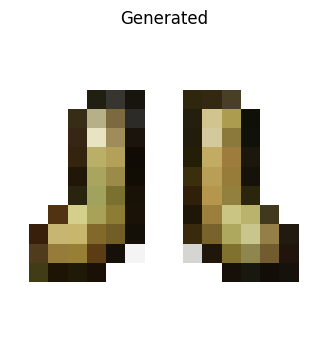

In [ ]:
generate_example_image(0,[30],[15],1.3)